In [ ]:
import math
import time
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
from random import choices
import copy
import os
import subprocess
from torchvision import transforms
import torch.nn as nn
import csv
import copy

cos_sim = lambda a,b: np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

## LSH class implementation

In [ ]:
## Exact same implementation, just a few more variables for the shrinkage process
class LSH_rp():
  def __init__(self, trainset, d = 784):
    self.array = trainset.data.numpy().reshape(len(trainset), d).astype('float') ## Turn dataset into a numpy array
    self.trainset_array = self.array - self.array.mean(axis = 0) ## Re-center the dataset array
    self.d = d

    self.ix_to_label = [] ## digit by index in the dataset

    self.label_to_ixs = {} ## indexes that represent each digit
    self.label_to_reps = {} ## How many repetitions by label

    for ix, (vec, label) in enumerate(trainset):
      self.ix_to_label.append(label)

      self.label_to_ixs[label] = self.label_to_ixs.get(label, [])
      self.label_to_ixs[label].append(ix)

      self.label_to_reps[label] = self.label_to_reps.get(label, 0) + 1

    self.num_labels = len(self.label_to_ixs)

  def hash_values(self, nbits = None, n_hashtables = None):
    if not nbits:
      nbits = int(math.log2(self.array.shape[0])/2) + 1
    if not n_hashtables:
      n_hashtables = int(math.log10(self.array.shape[0]))

    rand_tables = np.random.normal(0,1,(n_hashtables, nbits, self.d))

    self.tb_inthash_ix = [{} for i in range(n_hashtables)] ## save which indexes have each hash for each hash table
    self.n_hashtables = n_hashtables

    binary_array = (np.matmul(rand_tables, self.trainset_array.T) > 0).astype(int).transpose(0,2,1)
    self.hashes_array = binary_array.dot(np.flip(1<<np.arange(nbits))).T

    for ix in range(self.trainset_array.shape[0]):
      hash = self.hashes_array[ix]
      label = self.ix_to_label[ix]
      for i in range(self.n_hashtables):
        self.tb_inthash_ix[i][hash[i]] = self.tb_inthash_ix[i].get(hash[i], {lab:[] for lab in self.label_to_ixs.keys()})
        self.tb_inthash_ix[i][hash[i]][label].append(ix)

  def find_most_alike(self, ix):
    label = self.ix_to_label[ix]
    hash = self.hashes_array[ix]

    return set([j for i in range(self.n_hashtables) for j in self.tb_inthash_ix[i][hash[i]][label]]) - set([ix])

  def mean_dist(self):
    mean_th = {}

    Z = 1.65
    E = 0.05
    p = 0.5

    for label, N in self.label_to_reps.items():
      n = int(((Z**2 * N)*(p * (1-p))) / (((E**2)*(N-1)) + ((Z**2)*(p *(1-p))))) # Determine sample size
      curr_sample = np.random.choice(self.label_to_ixs[label], n)
      distance_sum = 0
      for ix in curr_sample:
        vec = self.array[ix]
        distance_sum += np.array([1-cos_sim(vec, self.array[i]) for i in self.find_most_alike(ix)]).mean()

      mean_th[label] = distance_sum/n

    return mean_th

### LSH random-shrink implementation

In [ ]:
## Similar to v0, but now elimination process is done randomly on each label, not on the full dataset.
def LSH_Shrink(rp, p):
  # Renaming
  vectors = rp.array
  labels = rp.ix_to_label
  ixs_by_label = copy.deepcopy(rp.label_to_ixs)

  th = rp.mean_dist()

  deletion_by_label = {label:int(n*p) for label, n in rp.label_to_reps.items()}

  chosen = []
  for label in ixs_by_label.keys():
    current_ixs = ixs_by_label[label]
    label_max_deletion = deletion_by_label[label]

    count = 0
    while count < label_max_deletion:
      try:
        ix = np.random.choice(current_ixs)
      except(ValueError):
        print(f"Se llegó al límite de eliminación de {label}'s")
        break

      chosen.append(ix)
      curr_vector = vectors[ix]
      current_ixs.remove(ix)

      alike_neighbours = rp.find_most_alike(ix)
      neighbours_dist = sorted([(i, 1-cos_sim(vectors[i], curr_vector)) for i in alike_neighbours], key = lambda x: x[1])

      local_count = 0
      local_max = int(len(alike_neighbours)*p)
      for alike_ix, distance in neighbours_dist:
        if count >= label_max_deletion or local_count >= local_max or distance > th[label]*(min(0.19+0.9*p,1)):
          break

        try:
          current_ixs.remove(alike_ix)
          count += 1
          local_count += 1
        except(ValueError):
          continue

  return chosen + [i for label in ixs_by_label.keys() for i in ixs_by_label[label]]

### Plotting random index function

In [ ]:
def plot_results(rp, ix = None): ## plot the first 15 similar images next to a given image vector
  if not ix:
    ix = np.random.choice(rp.label_to_ixs[np.random.choice(list(rp.label_to_ixs.keys()))]) ## get a random index to find similar images
  print(f'index: {ix}')
  k = 15 ## find k most similar images

  t0 = time.time()
  vec = rp.array[ix]
  sim_ixs = sorted(list(rp.find_most_alike(ix)), key = lambda i: 1-cos_sim(rp.array[i], vec))[:15]
  print(f'time looking for neighbours: {time.time()-t0:.3f} s')

  f, axarr = plt.subplots(4,4, figsize = (7,7), constrained_layout = True)
  axarr[0][0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
  axarr[0][0].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

  axarr[0][0].imshow(rp.array[ix].reshape(28,28).T, cmap='gray')
  axarr[0][0].set_title('Original image', fontsize = 9)
  for j in range(0,min(15, len(sim_ixs))):
    i = j+1
    axarr[i//4][i%4].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axarr[i//4][i%4].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    dist = 1-cos_sim(rp.array[ix], rp.array[sim_ixs[j]])
    axarr[i//4][i%4].set_title(f'{dist:.4f}', fontsize = 9)
    axarr[i//4][i%4].imshow(rp.array[sim_ixs[j]].reshape(28,28).T, cmap = 'gray')

## Data exploration, testing

In [ ]:
## Downloading and getting the E-MNIST letter dataset
trainset = torchvision.datasets.EMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor(), split = 'letters')
testset = torchvision.datasets.EMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor(), split = 'letters')

100%|██████████| 561753746/561753746 [00:22<00:00, 25431574.87it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


In [ ]:
rp = LSH_rp(trainset)

(1218.75, 413.00611470201017)

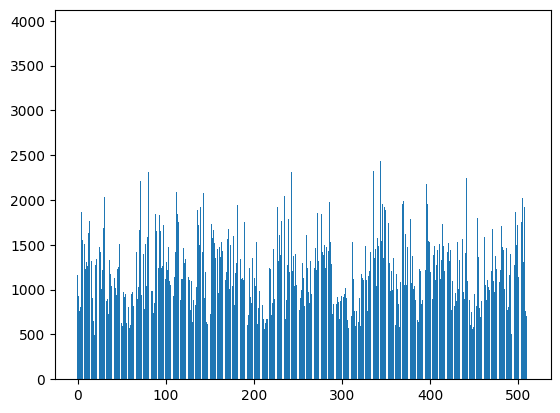

In [ ]:
## Plotting the distribution of images among possible hashes
n_bits = None             ## If None, an optimal number for nbits will be used
n_hashtables = None       ## If None, n_hashtables = log10(N), where N is the number of data points, not necesarily optimal

rp.hash_values(n_bits,n_hashtables)
N = rp.array.shape[0]

dict_counts = {}
for table in rp.tb_inthash_ix:
  for hash_int in table.keys():
    for label in rp.label_to_ixs.keys():
      dict_counts[hash_int] = dict_counts.get(hash_int, 0) + len(table[hash_int][label])

arr = np.array(list(dict_counts.values()))

plt.bar(dict_counts.keys(), dict_counts.values())
(arr.mean(), arr.std())

Text(0, 0.5, 'Mean cosinde distance')

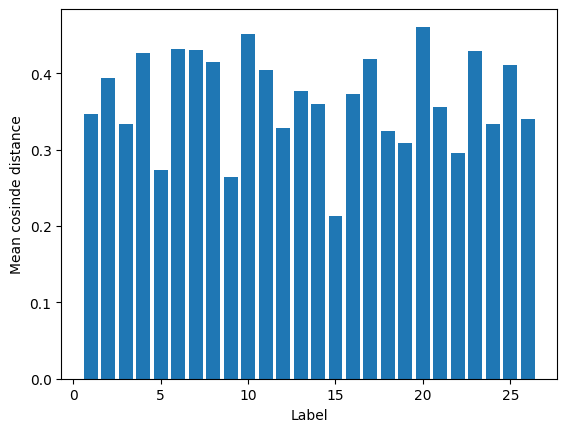

In [ ]:
## Plotting average cosine distance estimate along classes
label_to_dist = rp.mean_dist()
plt.bar(label_to_dist.keys(), label_to_dist.values())
plt.xlabel('Label')
plt.ylabel('Mean cosinde distance')

67784
index: 67784
time looking for neighbours: 0.015 s


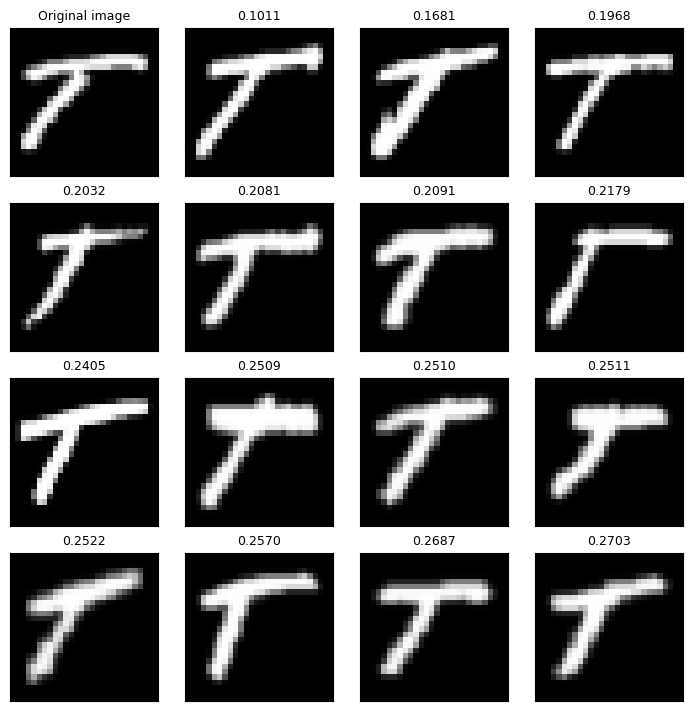

In [ ]:
## Chosing a label and a random index's neighbours
label = 20
ix = np.random.choice(rp.label_to_ixs[label]) if label else None

print(ix)
plot_results(rp, ix)

## Model implementation (LeNet)

In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.lenet = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1),
            nn.Linear(256, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )
    def forward(self, x):
        out = self.lenet(x)
        return out

# Training module
def train(epoch, net, criterion, optimizer, trainloader, device):
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    best_acc = 0
    best_loss = 999

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        train_loss = train_loss / (batch_idx + 1)
        train_acc = 100. * correct / total

        if best_acc < train_acc:
          best_acc = train_acc
          best_loss = train_loss

    return best_loss, best_acc

# Testing module
def test(epoch, net, criterion, testloader, device):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    best_acc = 0
    best_loss = 999

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        test_loss = test_loss / (batch_idx + 1)
        test_acc = 100. * correct / total

        if best_acc < test_acc:
            best_acc = test_acc
            best_loss = test_loss

    return best_loss, best_acc

def accuracy(rp, p):
  # SHRINKING
  t0 = time.time()
  rp.hash_values()
  reduced = LSH_Shrink(rp, p)
  trainset_shrinked = torch.utils.data.Subset(trainset, reduced)

  trainloader_MNIST = torch.utils.data.DataLoader(trainset_shrinked, batch_size=batch_size, shuffle=True, num_workers=2)
  testloader_MNIST = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

  # TRAINING
  learning_rate = 0.001
  epochs = 7
  batch_size = 256

  net = LeNet(num_classes=len(rp.label_to_reps.keys()) + 1)
  net.to("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

  for epoch in range(1, epochs+1):
      train_loss, train_acc = train(epoch, net, criterion, optimizer, trainloader_MNIST, device=device)
      test_loss, test_acc = test(epoch, net, criterion, testloader_MNIST, device=device)

  return (test_acc, time.time()-t0)

# Shrinking and training the model

In [ ]:
## Downloading and getting the E-MNIST letter dataset
trainset = torchvision.datasets.EMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor(), split = 'letters')
testset = torchvision.datasets.EMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor(), split = 'letters')

In [ ]:
rp = LSH_rp(trainset)

p: 0.00  |  acc: 87.0769  |  time: 353.4775
p: 0.10  |  acc: 86.8077  |  time: 356.4168


<ipython-input-2-fc0bc84f0391>:63: RuntimeWarning: Mean of empty slice.
  distance_sum += np.array([1-cos_sim(vec, self.array[i]) for i in self.find_most_alike(ix)]).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


p: 0.20  |  acc: 86.6490  |  time: 327.8365
p: 0.30  |  acc: 84.9808  |  time: 287.6483
p: 0.40  |  acc: 83.5481  |  time: 253.7147
p: 0.50  |  acc: 78.7260  |  time: 226.2120
p: 0.60  |  acc: 72.1779  |  time: 197.0460
p: 0.70  |  acc: 60.9279  |  time: 167.2596
p: 0.80  |  acc: 40.5529  |  time: 146.0856
Se llegó al límite de eliminación de 23's
Se llegó al límite de eliminación de 7's
Se llegó al límite de eliminación de 16's
Se llegó al límite de eliminación de 17's
Se llegó al límite de eliminación de 11's
Se llegó al límite de eliminación de 24's
Se llegó al límite de eliminación de 18's
Se llegó al límite de eliminación de 21's
Se llegó al límite de eliminación de 26's
Se llegó al límite de eliminación de 19's
Se llegó al límite de eliminación de 5's
Se llegó al límite de eliminación de 2's
Se llegó al límite de eliminación de 1's
Se llegó al límite de eliminación de 8's
Se llegó al límite de eliminación de 4's
Se llegó al límite de eliminación de 6's
p: 0.90  |  acc: 16.3413  |

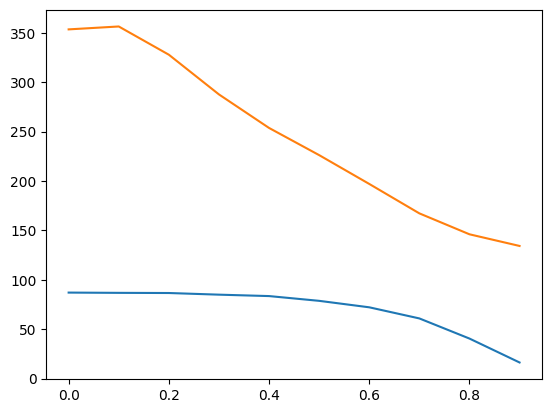

In [ ]:
acc_res = []
time_res = []
for p in range(10):
  local_res = accuracy(rp, p/10)
  print(f'p: {p/10:.2f}  |  acc: {local_res[0]:.4f}  |  time: {local_res[1]:.4f}')

  acc_res.append(local_res[0])
  time_res.append(local_res[1])

plt.plot([p/10 for p in range(10)], acc_res)
plt.plot([p/10 for p in range(10)], time_res)